# Assignment1 
###    吴岳 DZ260011

## 实验题目
应用编程语言实现梯度下降、随机梯度下降以及Adagrad算法。训练数据和测试数据可以自选，可以使用scikit-learn、pytorch库中的数据、自己处理的科学数据以及老师提供的数据等。

## 1. Data
Energy Distribution of repeating FRBs (cumulative energy distribution $N(>E)$ ) e.g. FRB 20201124A   ([ Zhang 2022 et al.](https://iopscience.iop.org/article/10.1088/1674-4527/ac98f7) )

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("FRB20201124A.csv",header=[0,1,2])
df

,BurstID,ObsDate,MJD,DM,Width,PeakFlux,Fluence,Energy_c,Energy_w,BandWidth,Width,PeakFlux,Fluence,Energy_w
,,,Barycentric,,FullBand,FullBand,FullBand,FullBand,FullBand,,LimitedBand,LimitedBand,LimitedBand,LimitedBand
,,,,(pc/cm^3),(ms),(mJy),(Jy ms),(1e37erg),(1e37erg),(MHz),(ms),(mJy),(Jy ms),(1e37erg)
0,1,20210926,59482.94451,412.97,3.31,12.39,0.041,1.1480,0.4590,200,3.81,22.50,0.086,0.4210
1,2,20210926,59482.94673,412.97,3.78,28.61,0.108,3.0230,1.2090,150,3.55,79.38,0.281,1.0380
2,3,20210926,59482.94701,412.97,4.34,5.99,0.026,0.7278,0.2911,50,5.18,32.52,0.168,0.2071
3,4,20210926,59482.94712,412.97,2.70,7.41,0.020,0.5598,0.2239,100,3.54,20.05,0.071,0.1747
4,5,20210926,59482.94736,412.97,4.47,9.61,0.043,1.2040,0.4814,100,4.00,38.02,0.152,0.3740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,877,20210929,59485.82367,412.55,2.75,7.65,0.021,0.5878,0.2351,100,1.94,24.94,0.048,0.1187
877,878,20210929,59485.82374,412.55,3.70,410.28,1.516,42.4300,16.9700,300,3.31,907.52,3.005,22.1700


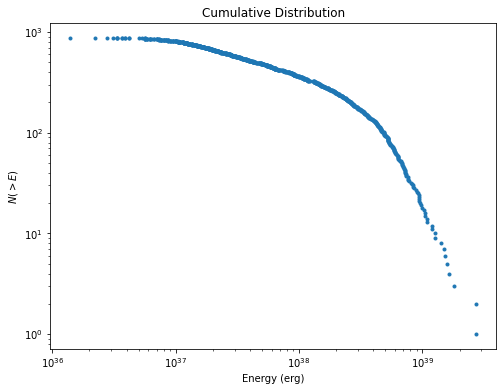

In [2]:
Energy_wFB = df['Energy_c'].values[:,0]*1e37
# 画累积分布图
plt.figure(figsize=(8, 6))
sorted_data = np.sort(Energy_wFB)
plt.loglog(sorted_data, len(Energy_wFB)-np.arange(0,len(Energy_wFB)),'.' )
plt.xlabel('Energy (erg)')
plt.ylabel('$N(>E)$')
plt.title('Cumulative Distribution')
plt.show()

## 2. Basic Function
### 2.1 Loss Function
a. $\sum_{i=0}^{N} \frac{1}{N}\left(\log(F(x^i)) - \log(\hat{y}^i) \right)^2$ 
I use this in this assignment, which is equivalent to fitting log(y).

b. $\sum_{i=0}^{N} \frac{1}{N} \sqrt{ \left|F(x^i) - \hat{y}^i \right| } $


c. $\sum_{i=0}^{N} \frac{1}{N} \left(F(x^i) - \hat{y}^i \right)^2$


### 2.2 Model Function
a. Band Function (exponentially connected broken power law)
$$
F_1(E)= \begin{cases}A E^{{\alpha}} e^{\left(-E / E_\mathrm{b}\right)} & E \leq({\alpha}-{\beta}) E_\mathrm{b} \\ A E^{{\beta}}\left[\frac{({\alpha}-{\beta}) E_\mathrm{b}}{e}\right]^{{\alpha}-{\beta}} & E \gt({\alpha}-{\beta}) E_\mathrm{b}\end{cases}
$$
b. Broken Power Law
$$
F_2(E)= \begin{cases}A E^{{\alpha}}  & E \leq  E_\mathrm{b} \\ 
              A E^{{\beta}} E_\mathrm{b}^{{\alpha}-{\beta}} & E \gt E_\mathrm{b}\end{cases}
$$


## 3. Algorithm Description

### 3.1 Gradient Descent
#### a. Pick the initial values $w^0=\left(A^0,\alpha^0,\beta^0,E_\mathrm{b}^0)\right)$ randomly,

#### b. Calculate gradient at $w^0$: $\nabla L \left(w^0\right)$

$$\begin{aligned}
&\frac{\partial L}{\partial A} =  \sum_{i=0}^{N} -2(\hat{y}^i-F_1(E^i))\cdot F_1(E^i)/A \\ 
\\
&\frac{\partial L}{\partial \alpha}= \begin{cases}\sum_i -2(\hat{y}^i-F_1(E^i))\cdot F_1(E^i)log(E^i) 
                                                    &E^i\leq({\alpha}-{\beta})E_\mathrm{b}\\ 
                                 \sum_i -2(\hat{y}^i-F_1(E^i))\cdot F_1(E^i)(log(\alpha-\beta)+1) 
                                                    & E^i \gt({\alpha}-{\beta})E_\mathrm{b}\end{cases}\\ 
\\                                                   
&\frac{\partial L}{\partial \beta} = \begin{cases} 0                 &E^i\leq({\alpha}-{\beta})E_\mathrm{b}\\ 
                                 \sum_i -2(\hat{y}^i-F_1(E^i))\cdot F_1(E^i)(log(E^i)-log(\alpha-\beta)-1) 
                                                    & E^i \gt({\alpha}-{\beta})E_\mathrm{b}\end{cases}\\ 
\\
&\frac{\partial L}{\partial E_\mathrm{b}} = \begin{cases} \sum_i -2(\hat{y}^i-F_1(E^i))\cdot F_1(E^i)E^i/E_\mathrm{b}^2                 &E^i\leq({\alpha}-{\beta})E_\mathrm{b}\\ 
                                 \sum_i -2(\hat{y}^i-F_1(E^i))\cdot F_1(E^i)(\alpha-\beta)/E_\mathrm{b}
                                                    & E^i \gt({\alpha}-{\beta})E_\mathrm{b}\end{cases}\\ 
\end{aligned}
$$
#### c. Move the next step: $ w^1= w^0-\eta \nabla L \left(w^0\right)$ 

#### d. Calculate gradient at $w^1$: $\nabla L \left(w^1\right)$

#### e. Move the next step: $ w^2= w^1-\eta \nabla L \left(w^1\right)$ 

#### f. …… (many iteration)

#### g. end (maximum iteration / minimum Loss)

### 

### 3.2 Stochastic Gradient Descent (SGD)

#### In Gradient Descent  Algorithm Loss is the summation over all training samples, however in SGD Loss is current one sample

#### b/d. Pick an example $x^n$, Calculate gradient $\nabla L^{n}$ at $w^{i-1}$ with only one sample $n$

#### c/e. Move the next step: $ w^i= w^{i-1}-\eta \nabla L^{n} \left(w^{i-1}\right)$ 

### 

### 3.3 Adagrad
#### Aptive learning rate: Reduce the learning rate by some factors every few epochs. 

#### Divide the learning rate of each parameter by the root mean square of its previous derivatives.
#### c/e. The new step becomes:
 $$ w^{t+1}= w^t-\frac{\eta^t}{\sigma^t}g^t,$$
#### where $\eta^t = \frac{\eta}{t+1}$,  $\sigma^t = \sqrt{\frac{1}{t+1}\sum_{i=0}^t (g^i)^2}$ and $g^t=\frac{\partial L\left(w^t\right)}{\partial w} $， i.e.
$$ w^{t+1}= w^t-\frac{\eta}{\sqrt{\sum_{i=0}^t (g^i)^2}}\frac{\partial L\left(w^t\right)}{\partial w}.$$


#### 流程图
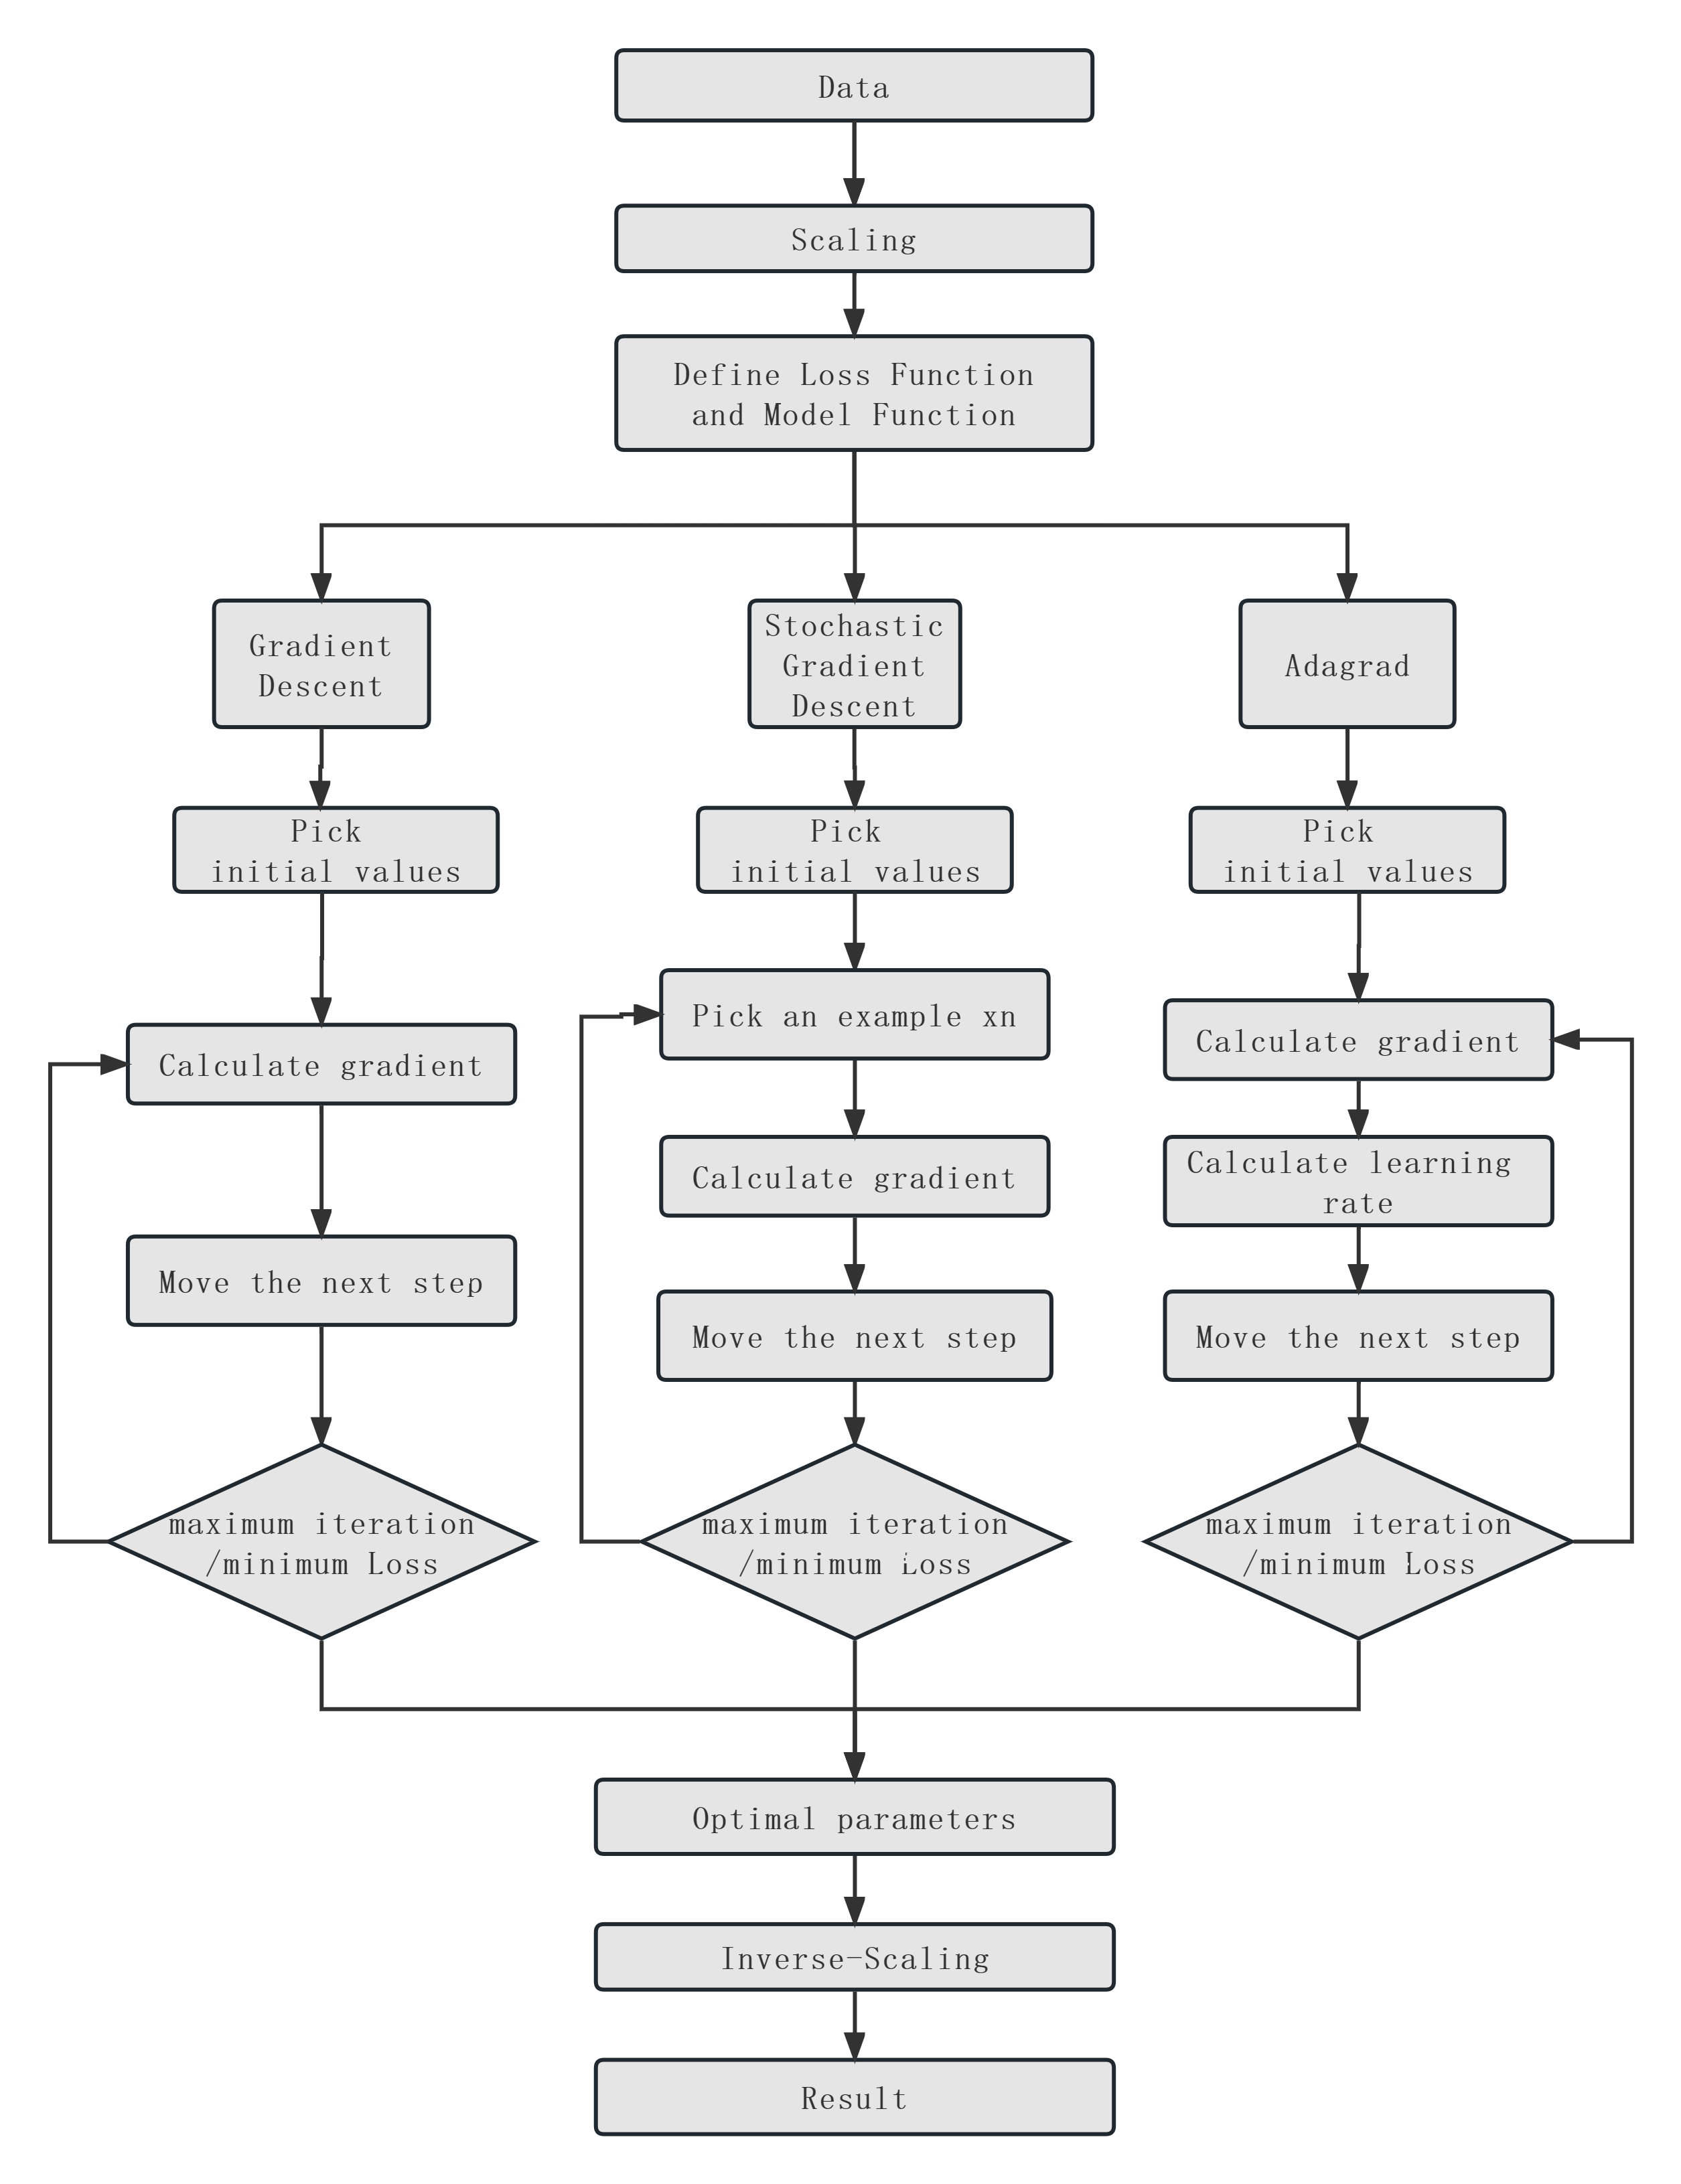

## 4. Source code

In [81]:
# 定义模型
def band_function(x, w):
    [A, alpha, beta, Eb] = w
    y1 = A * x**alpha * np.exp(-x/Eb) * (x<=(alpha-beta)*Eb)
    y2 = A * x**beta * ((alpha-beta)*Eb/np.exp(1))**(alpha-beta) *(x>(alpha-beta)*Eb)
    return y1+y2


# 定义损失函数（均方误差）
def mean_squared_error(y_pred, y_true, Method = "Log"):
    if (Method=="Log"):
        return np.mean((np.log(y_pred) - np.log(y_true))**2) 
    elif (Method=="Log2"):
        return np.mean((np.log(np.abs(y_pred - y_true)))**2)
    else:
        return np.mean((y_pred - y_true)**2)


# 1. 计算梯度及步长
def compute_gradients(x, y, w, Method = "Log"):
    [A, alpha, beta, Eb] = w
    n = len(x)
    y_pred = band_function(x, w)
    da =  np.log(x) * (x<=(alpha-beta)*Eb ) + ( np.log(alpha-beta)+1 ) * ( x>(alpha-beta)*Eb )
    db =  0 * (x<=(alpha-beta)*Eb ) + ( np.log(x)-np.log(alpha-beta)-1 ) * ( x>(alpha-beta)*Eb )
    de =  x/Eb**2 * (x<=(alpha-beta)*Eb ) + (alpha-beta)/Eb * ( x>(alpha-beta)*Eb )
    if (Method=="Log"):
        dA = (2/n) * np.dot(np.ones(n)/A, (np.log(y_pred) - np.log(y)) )  
        dalpha = (2/n) * np.dot(1*da, (np.log(y_pred) - np.log(y))  )        
        dbeta = (2/n) * np.dot(1*db, (np.log(y_pred) - np.log(y))   )   
        dEb = (2/n) * np.dot(1*de,  (np.log(y_pred) - np.log(y))  )
    elif (Method=="Sqrt"):
        bias = np.maximum( np.abs(y_pred - y), 1e-8)
        dA = (0.5/n) * np.dot(y_pred/A,  np.sign(y_pred - y) /  bias **0.5   )
        dalpha = (0.5/n) * np.dot(y_pred*da, np.sign(y_pred - y) / bias**0.5   )
        dbeta = (0.5/n) * np.dot(y_pred*db, np.sign(y_pred - y) / bias**0.5  ) 
        dEb = (0.5/n) * np.dot(y_pred*de, np.sign(y_pred - y) / bias**0.5  )
    else:
        dA = (2/n) * np.dot(y_pred/A, (y_pred - y))
        dalpha = (2/n) * np.dot(y_pred*da,(y_pred - y)) 
        dbeta = (2/n) * np.dot(y_pred*db, (y_pred - y))
        dEb = (2/n) * np.dot(y_pred*de, (y_pred - y))
    return dA, dalpha, dbeta, dEb


# 2. 计算随机梯度及步长
def compute_Stochastic_gradients(x, y, w, Method = "Log"): 
    [A, alpha, beta, Eb] = w
    i = random.randint(0, len(x)-1 )
    x =x[i]
    y = y[i]
    y_pred = band_function(x, w)
    da =  np.log(x) * (x<=(alpha-beta)*Eb ) + ( np.log(alpha-beta)+1 ) * ( x>(alpha-beta)*Eb )
    db =  0 * (x<=(alpha-beta)*Eb ) + ( np.log(x)-np.log(alpha-beta)-1 ) * ( x>(alpha-beta)*Eb )
    de =  x/Eb**2 * (x<=(alpha-beta)*Eb ) + (alpha-beta)/Eb * ( x>(alpha-beta)*Eb )
    if (Method=="Log"):
        dA = 2 * ( 1/A * ( np.log(y_pred) - np.log(y) ) )  
        dalpha = 2 * (1*da * ( np.log(y_pred) - np.log(y) )  )       
        dbeta = 2 * ( 1*db * ( np.log(y_pred) - np.log(y) ) )   
        dEb = 2 * (1*de * (np.log(y_pred) - np.log(y))  )
    elif (Method=="Sqrt"):
        bias = np.maximum( np.abs(y_pred - y), 1e-5)
        dA = (0.5) * np.dot(y_pred/A,  np.sign(y_pred - y) /  bias **0.5   )
        dalpha = (0.5) * np.dot(y_pred*da, np.sign(y_pred - y) / bias**0.5   )
        dbeta = (0.5) * np.dot(y_pred*db, np.sign(y_pred - y) / bias**0.5  ) 
        dEb = (0.5) * np.dot(y_pred*de, np.sign(y_pred - y) / bias**0.5  )
    else:
        dA = 2 * (y_pred/A * (y_pred - y))
        dalpha = 2 * (y_pred*da * (y_pred - y)) 
        dbeta = 2 * (y_pred*db * (y_pred - y))
        dEb = 2 * (y_pred*de * (y_pred - y))
    return dA, dalpha, dbeta, dEb


# 3. 计算梯度及自适应步长
def compute_Adagrad(x, y, w, SdL, Method = "Log"): 
    [A, alpha, beta, Eb] = w
    n = len(x)
    y_pred = band_function(x, w)
    da =  np.log(x) * (x<=(alpha-beta)*Eb ) + ( np.log(alpha-beta)+1 ) * ( x>(alpha-beta)*Eb )
    db =  0 * (x<=(alpha-beta)*Eb ) + ( np.log(x)-np.log(alpha-beta)-1 ) * ( x>(alpha-beta)*Eb )
    de =  x/Eb**2 * (x<=(alpha-beta)*Eb ) + (alpha-beta)/Eb * ( x>(alpha-beta)*Eb )
    if (Method=="Log"):
        dA = (2/n) * np.dot(np.ones(n)/A, (np.log(y_pred) - np.log(y)) )  
        dalpha = (2/n) * np.dot(1*da, (np.log(y_pred) - np.log(y))  )        
        dbeta = (2/n) * np.dot(1*db, (np.log(y_pred) - np.log(y))   )   
        dEb = (2/n) * np.dot(1*de,  (np.log(y_pred) - np.log(y))  )
    elif (Method=="Sqrt"):
        bias = np.maximum( np.abs(y_pred - y), 1e-5)
        dA = (0.5/n) * np.dot(y_pred/A,  np.sign(y_pred - y) /  bias **0.5   )
        dalpha = (0.5/n) * np.dot(y_pred*da, np.sign(y_pred - y) / bias**0.5   )
        dbeta = (0.5/n) * np.dot(y_pred*db, np.sign(y_pred - y) / bias**0.5  ) 
        dEb = (0.5/n) * np.dot(y_pred*de, np.sign(y_pred - y) / bias**0.5  )
    else:
        dA = (2/n) * np.dot(y_pred/A, (y_pred - y))
        dalpha = (2/n) * np.dot(y_pred*da,(y_pred - y)) 
        dbeta = (2/n) * np.dot(y_pred*db, (y_pred - y))
        dEb = (2/n) * np.dot(y_pred*de, (y_pred - y))
    SdL = SdL + np.array([dA, dalpha, dbeta, dEb])**2
    return [dA, dalpha, dbeta, dEb, SdL]


# 梯度下降算法拟合
def gradient_descent(x, y, w0, learning_rate = 0.01, max_iterations = 1000, Method = 'GD',LossMethod = "Log"):
    [A, alpha, beta, Eb] = w0
    w = np.array([w0])
    Loss0 = mean_squared_error(band_function(x, w0),y)
    L = np.array(Loss0)
    SdL = np.zeros(4)
    for iteration in range(max_iterations):
        if (Method == 'Adagrad'):
            [dA, dalpha, dbeta, dEb, SdL] = compute_Adagrad(x, y, w[iteration,:], SdL, LossMethod)
            A = max(A - learning_rate/np.sqrt(SdL[0]) * dA, 0)                           # A>0
            alpha = min( alpha - learning_rate/np.sqrt(SdL[1]) * dalpha, -np.exp(-10) ) # alpha<0
            beta = min( beta - learning_rate/np.sqrt(SdL[2]) * dbeta  ,-np.exp(-10) )   # beta<0
            Eb = max(Eb - learning_rate/np.sqrt(SdL[3]) * dEb, np.min(x) )              # Eb>Emin
        else:
            if (Method == 'SGD'):
                dA, dalpha, dbeta, dEb = compute_Stochastic_gradients(x, y, w[iteration,:], LossMethod)
            else:
                dA, dalpha, dbeta, dEb = compute_gradients(x, y, w[iteration,:], LossMethod)              
            A = max(A - learning_rate * dA, 0)                           # A>0
            alpha = min( alpha - learning_rate * dalpha, -np.exp(-10) ) # alpha<0
            beta = min( beta - learning_rate * dbeta  ,-np.exp(-10) )   # beta<0
            Eb = max(Eb - learning_rate * dEb, np.min(x) )              # Eb>Emin
        
        w = np.append(w, [[A, alpha, beta, Eb]], axis=0)       
        y_pred = band_function(x, w[-1,:])
        Loss = mean_squared_error(y_pred, y)
        L = np.append(L, [Loss])
#         if (iteration%100==0):
#             print(w[iteration,:],L[iteration],SdL) 
    return  [w, L]


### Result

### 4.1 Gradient Descent

Optimal A (Scaled): 0.284110109233882
Optimal alpha: -0.20647463131929297
Optimal beta: -2.999978088887762
Optimal Eb (Scaled): 0.1331356311970068
Turning Point (alpha-beta)Eb (Scaled): 0.37191484607439906
Loss: 0.002307092357063164


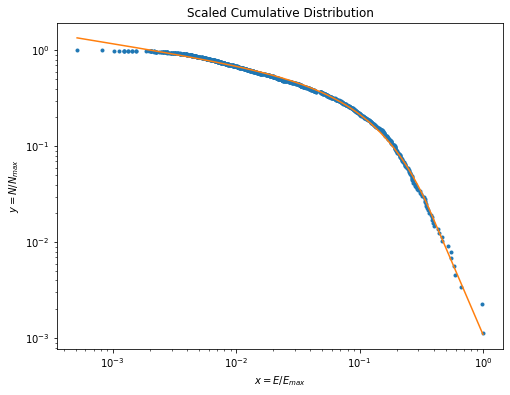

In [57]:
#Scaling
X = sorted_data
Y = len(Energy_wFB)-np.arange(0,len(Energy_wFB))
x = X /np.max(X) 
y = Y /np.max(Y) 

# 执行梯度下降算法
learning_rate = 0.002
max_iterations = 10000
w0 = [0.2, -0.2, -3, 0.2] #[A0, alpha0, beta0, Eb0]
[w1, L1]= gradient_descent(x, y, w0, learning_rate, max_iterations)
[ optimal_A, optimal_alpha, optimal_beta, optimal_Eb ] =w1[-1,:]
print("Optimal A (Scaled):", optimal_A)
print("Optimal alpha:", optimal_alpha)
print("Optimal beta:", optimal_beta)
print("Optimal Eb (Scaled):", optimal_Eb)
print("Turning Point (alpha-beta)Eb (Scaled):", (optimal_alpha-optimal_beta)*optimal_Eb )
print("Loss:", L1[-1])

plt.figure(figsize=(8, 6))
plt.loglog(x, y,'.' )
plt.loglog(x, band_function(x, w1[-1,:]))
plt.xlabel('$x=E/E_{max}$ ')
plt.ylabel('$y=N/N_{max}$')
plt.title('Scaled Cumulative Distribution')
plt.show()

#### Back to real value

In [14]:
def print_inScaling(w):
    # 输出最优真实解
    [ optimal_A, optimal_alpha, optimal_beta, optimal_Eb ] = w
    optimal_A = optimal_A*np.max(Y)/np.max(X)**optimal_alpha
    optimal_Eb = optimal_Eb*np.max(X)
    print("Optimal A:", optimal_A)
    print("Optimal alpha:", optimal_alpha)
    print("Optimal beta:", optimal_beta)
    print("Optimal Eb:", optimal_Eb)
    print("Turning Point (alpha-beta)Eb:", (optimal_alpha-optimal_beta)*optimal_Eb )
    
    plt.figure(figsize=(8, 6))
    plt.loglog(X, Y,'.' )
    plt.loglog(X, band_function(X, [optimal_A, optimal_alpha, optimal_beta, optimal_Eb]) )
    plt.xlabel('Energy (erg)')
    plt.ylabel('$N(>E)$')
    plt.title('Cumulative Distribution')
    plt.show()

Optimal A: 34740210303.05067
Optimal alpha: -0.20647463131929297
Optimal beta: -2.999978088887762
Optimal Eb: 3.626614593806465e+38
Turning Point (alpha-beta)Eb: 1.013096040706663e+39


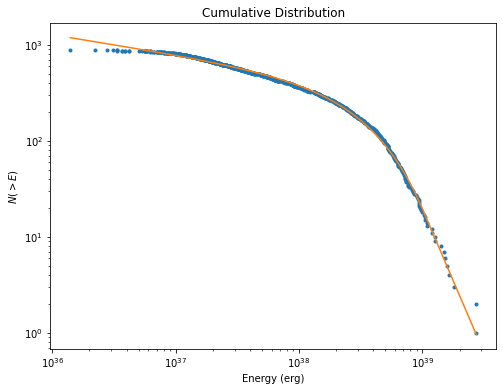

In [15]:
print_inScaling(w1[-1,:]) 

### 4.2 Stochastic Gradient Descent

Loss: 0.00318996752175555
Optimal A: 137001299246.74054
Optimal alpha: -0.22226736152277612
Optimal beta: -3.0267827780246486
Optimal Eb: 3.8351666466936574e+38
Turning Point (alpha-beta)Eb: 1.0755783985506152e+39


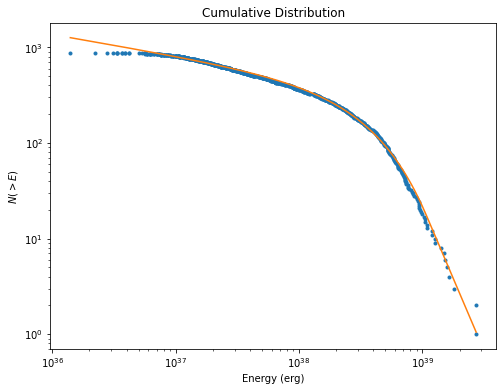

In [16]:
#Scaling
X = sorted_data
Y = len(Energy_wFB)-np.arange(0,len(Energy_wFB))
x = X /np.max(X) 
y = Y /np.max(Y) 

# 执行随机梯度下降算法
learning_rate = 0.002
max_iterations = 10000
w0 = [0.2, -0.2, -3, 0.2] #[A0, alpha0, beta0, Eb0]
[w2, L2]= gradient_descent(x, y, w0, learning_rate, max_iterations, 'SGD')
print("Loss:", L2[-1])
print_inScaling(w2[-1,:]) 

### 4.3 Adagrad

Loss: 0.0026438920580153964
Optimal A: 197287199649.86584
Optimal alpha: -0.22658626420493347
Optimal beta: -2.60469477513584
Optimal Eb: 3.717765906894308e+38
Turning Point (alpha-beta)Eb: 8.841250744834113e+38


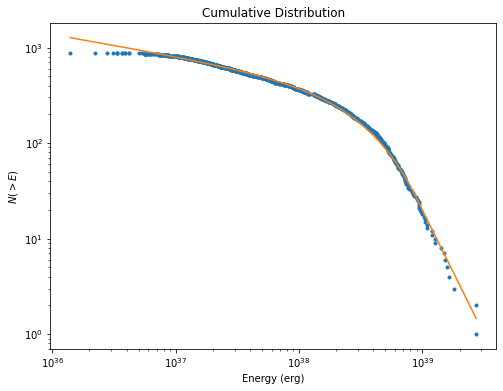

In [17]:
#Scaling
X = sorted_data
Y = len(Energy_wFB)-np.arange(0,len(Energy_wFB))
x = X /np.max(X) 
y = Y /np.max(Y) 

# 执行随机梯度下降算法
learning_rate = 0.002
max_iterations = 10000
w0 = [0.2, -0.2, -3, 0.2] #[A0, alpha0, beta0, Eb0]
[w3, L3]= gradient_descent(x, y, w0, learning_rate, max_iterations, 'Adagrad')
print("Loss:", L3[-1])
print_inScaling(w3[-1,:]) 

###  5. Discussion

#### Loss及参数随迭代次数的变化

In [34]:
def plot_iteration(w,L):
    plt.figure(figsize=(12, 9))

    # Loss Function
    plt.subplot(311)
    plt.loglog(L)
    plt.title('Loss Function')
    plt.xlabel('Iteration')
    plt.ylabel('Loss Function')

    # alpha
    plt.subplot(323)
    plt.plot(w[:,1])
    plt.xscale ('log')
    plt.title(r'$\alpha$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$\alpha$')

    # # beta
    plt.subplot(324)
    plt.plot(w[:,2])
    plt.xscale ('log')
    plt.title(r'$\beta$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$\beta$')

    # Eb
    plt.subplot(325)
    plt.plot(w[:,3])
    plt.xscale ('log')
    plt.title(r'$E_\mathrm{b}$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$E_\mathrm{b}/E_{max}$')

    #A
    plt.subplot(326)
    ax = plt.gca()
    plt.plot(w[:,0])
    plt.xscale ('log')
    plt.title(r'$A/N_\mathrm{max} E_{max}^{\alpha}$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$A/N_\mathrm{max} E_{max}^{\alpha}$')

    # 显示图形
    plt.subplots_adjust(wspace=0.3, hspace=0.45)
    plt.show()

#### 5.1 Gradient Descent

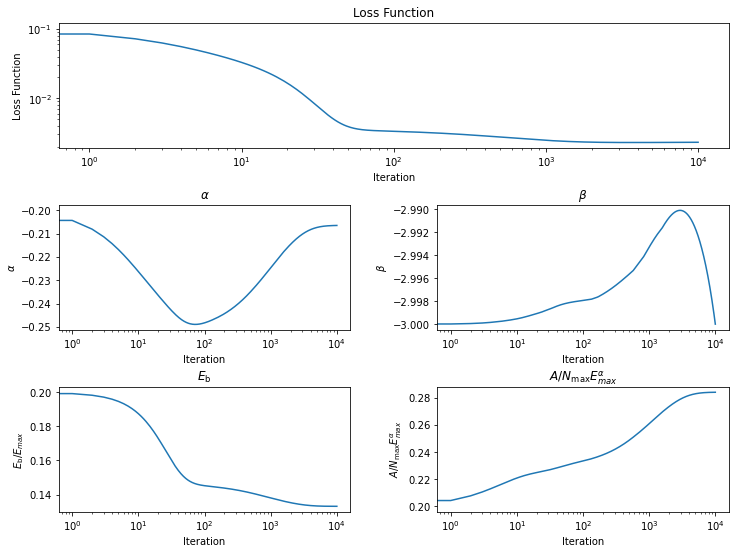

In [35]:
plot_iteration(w1,L1)

#### 5.2 Stochastic Gradient Descent

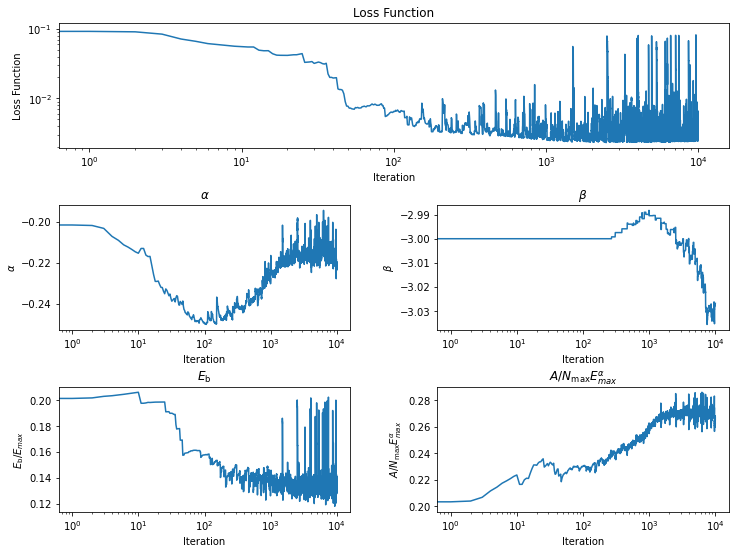

In [36]:
plot_iteration(w2,L2)

#### 5.3 Adagrad

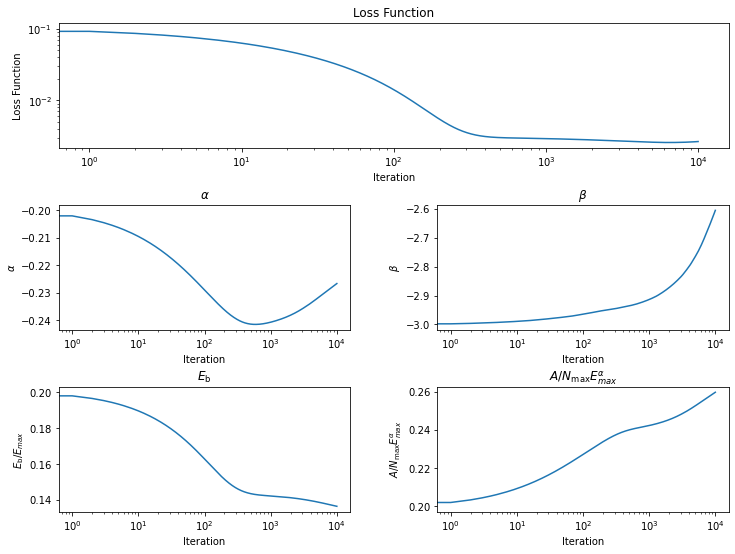

In [37]:
plot_iteration(w3,L3)

#### [ Zhang 2022 et al.](https://iopscience.iop.org/article/10.1088/1674-4527/ac98f7)中的结果为$\alpha=-0.22\pm0.01,\ \beta=-3.27\pm0.34, \ \mathrm{Turning Point} (\alpha-\beta)E_\mathrm{b}=(1.1\pm0.2)\times10^{39}\mathrm{erg}$
#### 可以看到Gradient Descent的Loss下降较快，Stochastic Gradient Descent有震荡，Adagrad下降较为平缓，
#### 有的参数最终结果并未平滑，对该参数的限制并不太好，可能与模型或Loss function的选取有关，需进一步考虑
#### 三个结果并不相同但Loss都很小可能与局域最小值有关。


### 不同Loss Functioni间比较

In [22]:
def plot_iteration2(w1, L1, w2, L2, w3, L3):
    plt.figure(figsize=(12, 9))

    # Loss Function
    plt.subplot(311)
    plt.loglog(L1)
    plt.loglog(L2)
    plt.loglog(L3)
    plt.title('Loss Function')
    plt.xlabel('Iteration')
    plt.ylabel('Loss Function')

    # alpha
    plt.subplot(323)
    plt.plot(w1[:,1])
    plt.plot(w2[:,1])
    plt.plot(w3[:,1])    
    plt.xscale ('log')
    plt.title(r'$\alpha$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$\alpha$')

    # # beta
    plt.subplot(324)
    plt.plot(w1[:,2])
    plt.plot(w2[:,2])
    plt.plot(w3[:,2])
    plt.xscale ('log')
    plt.title(r'$\beta$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$\beta$')

    # Eb
    plt.subplot(325)
    plt.plot(w1[:,3])
    plt.plot(w2[:,3])
    plt.plot(w3[:,3])
    plt.xscale ('log')
    plt.title(r'$E_\mathrm{b}$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$E_\mathrm{b}/E_{max}$')

    #A
    plt.subplot(326)
    ax = plt.gca()
    plt.plot(w1[:,0])
    plt.plot(w2[:,0])    
    plt.plot(w3[:,0])
    plt.xscale ('log')
    plt.title(r'$A/N_\mathrm{max} E_{max}^{\alpha}$')
    plt.xlabel('Iteration')
    plt.ylabel(r'$A/N_\mathrm{max} E_{max}^{\alpha}$')

    # 显示图形
    plt.subplots_adjust(wspace=0.3, hspace=0.45)
    plt.show()

Optimal A: 34740210303.05067
Optimal alpha: -0.20647463131929297
Optimal beta: -2.999978088887762
Optimal Eb: 3.626614593806465e+38
Turning Point (alpha-beta)Eb: 1.013096040706663e+39


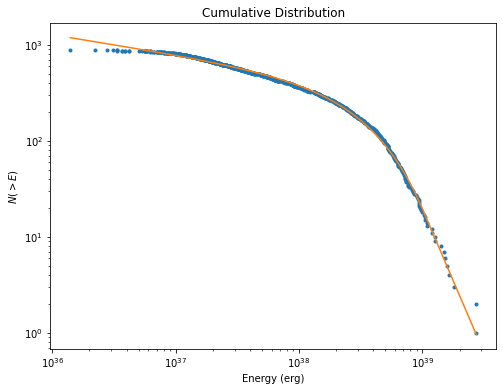

Loss1: 0.002307092357063164 

Optimal A: 177666018546.49817
Optimal alpha: -0.22530759175196927
Optimal beta: -2.919692685901623
Optimal Eb: 3.915649637488391e+38
Turning Point (alpha-beta)Eb: 1.0550268017161217e+39


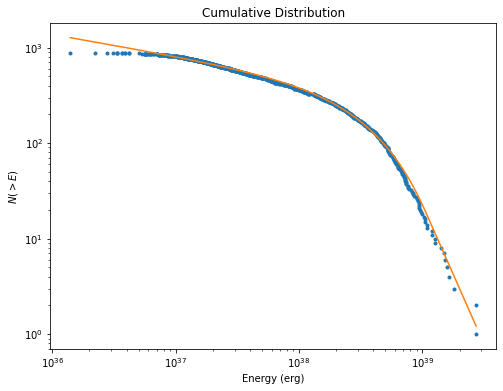

Loss: 0.0038478382823185745 

Optimal A: 46595034160.88863
Optimal alpha: -0.2098888858865374
Optimal beta: -2.9999636801301373
Optimal Eb: 3.64629423509803e+38
Turning Point (alpha-beta)Eb: 1.0173433637742761e+39


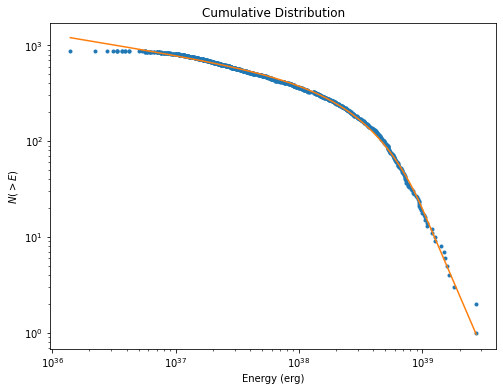

Loss: 0.0023076746941420403 



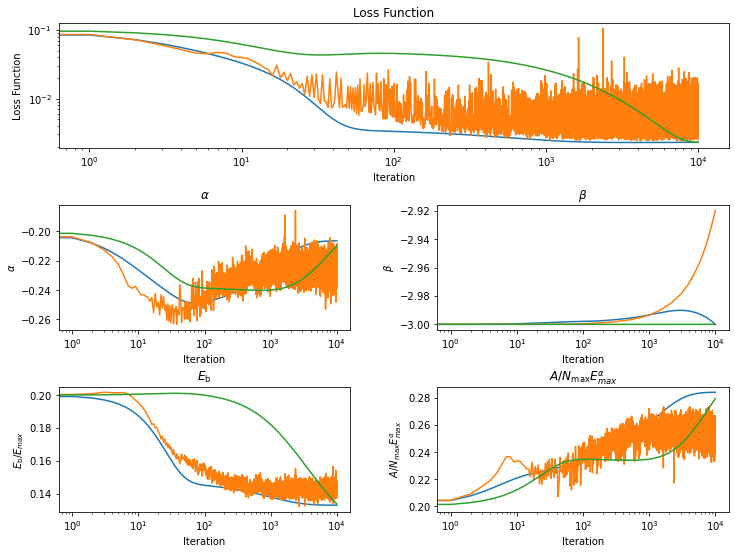

In [82]:
X = sorted_data
Y = len(Energy_wFB)-np.arange(0,len(Energy_wFB))
x = X /np.max(X) 
y = Y /np.max(Y) 

learning_rate = 0.002
max_iterations = 10000
w0 = [0.2, -0.2, -3, 0.2] #[A0, alpha0, beta0, Eb0]
[w5_1, L5_1]= gradient_descent(x, y, w0, learning_rate, max_iterations, 'GD', 'Log')
print_inScaling(w5_1[-1,:]) 
print("Loss1:", L5_1[-1], '\n')
[w5_2, L5_2]= gradient_descent(x, y, w0, learning_rate, max_iterations, 'GD', 'Sqrt')
print_inScaling(w5_2[-1,:]) 
print("Loss:", L5_2[-1], '\n')
[w5_3, L5_3]= gradient_descent(x, y, w0, learning_rate, max_iterations, 'GD', 'Normal')
print_inScaling(w5_3[-1,:])
print("Loss:", L5_3[-1], '\n')

plot_iteration2(w5_1, L5_1,w5_2, L5_2,w5_3, L5_3 )

### 6. 其他拟合方法

#### 6.1Curve fit

A  = 0.30431350636813254 ± 0.004231813597801799
alpha = -0.19463073243499543 ± 0.0025291998642317497
beta = -2.3196508794622086 ± 0.7086864271849876
Eb = 0.12188713470760379 ± 0.0019958189827194717
Loss =  0.003995008654920251


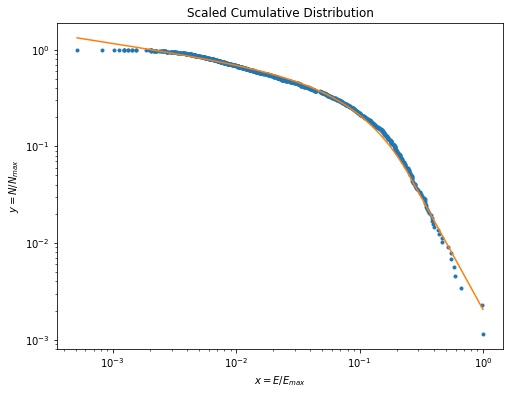

In [17]:
from scipy import optimize as op

def func(x, A, alpha, beta, Eb):
    y1 = A * x**alpha * np.exp(-x/Eb) * (x<=(alpha-beta)*Eb)
    y2 = A * x**beta * ((alpha-beta)*Eb/np.exp(1))**(alpha-beta) *(x>(alpha-beta)*Eb)
    return y1+y2

popt, pcov = op.curve_fit(func, x, y, p0=[0.2, -0.2, -3., 0.2], bounds=([0., -1., -4., 0.] , [10., 0., 0., 2.]) )
perr = np.sqrt(np.diag(pcov))
for name, popt_, perr_ in zip(['A','alpha','beta','Eb'], popt, perr):
    print(u'{:2s} = {} ± {}'.format(name, popt_, perr_))
y_pred = band_function(x, popt)
Loss = mean_squared_error(y_pred, y)
print('Loss = ', Loss)
plt.figure(figsize=(8, 6))
plt.loglog(x, y,'.' )
plt.loglog(x, band_function(x, popt ) )
plt.xlabel('$x=E/E_{max}$ ')
plt.ylabel('$y=N/N_{max}$')
plt.title('Scaled Cumulative Distribution')
plt.show()

#### 6.2 mcmc

In [19]:
# 定义模型
def band_function(x, w):
    [A, alpha, beta, Eb] = w
    y1 = A * x**alpha * np.exp(-x/Eb) * (x<=(alpha-beta)*Eb)
    y2 = A * x**beta * ((alpha-beta)*Eb/np.exp(1))**(alpha-beta) *(x>(alpha-beta)*Eb)
    return y1+y2

def log_likelihood(theta, x, y, yerr):
    #A, alpha, beta, Eb, log_f = theta
    A, alpha, beta, Eb = theta
    model = band_function(x, [A, alpha, beta, Eb])
    #sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    yerr = np.maximum(yerr, 1e-10)  # 确保 y_err 不为零
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    #A, alpha, beta, Eb, log_f = theta
    A, alpha, beta, Eb = theta
    if 0. < A < 5. and beta < alpha < 0. and -4. < beta < alpha and 0. < Eb < 2.: #  and -10. < log_f < 1.:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [102]:
import emcee

initial = np.array([0.2, -0.2, -3, 0.2]) 

pos = initial + 1e-2 * np.random.randn(40, 4)
nwalkers, ndim = pos.shape


sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, 1e-1*y )
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 274.29it/s]


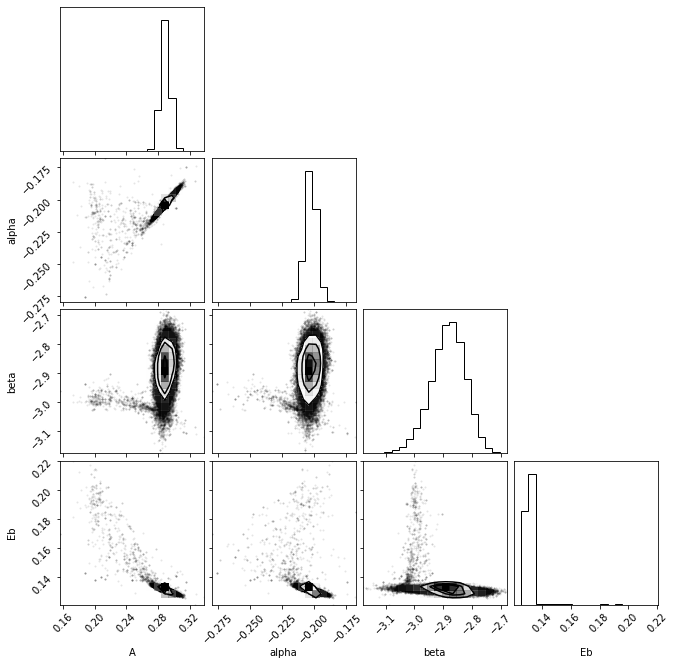

In [108]:
import corner
flat_samples = sampler.get_chain(discard=0, thin=2, flat=True)
labels = ["A", "alpha", "beta", "Eb"]
fig = corner.corner(
    flat_samples, labels=labels
);

In [109]:
labels = ["A", "alpha", "beta", "Eb"]
from IPython.display import display, Math

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

(13040, 4)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Loss =  0.0021834349215578246


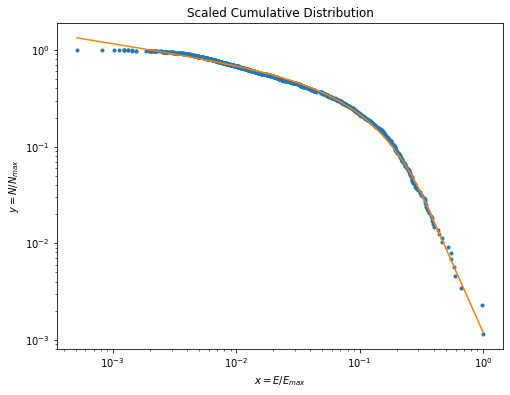

In [110]:
popt = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    popt[i] = mcmc[1]
    
y_pred = band_function(x, popt)
Loss = mean_squared_error(y_pred, y)
print('Loss = ', Loss)
plt.figure(figsize=(8, 6))
plt.loglog(x, y,'.' )
plt.loglog(x, band_function(x, popt ) )
plt.xlabel('$x=E/E_{max}$ ')
plt.ylabel('$y=N/N_{max}$')
plt.title('Scaled Cumulative Distribution')
plt.show()